# `tf_gnns`: A Hackable `graph_nets` library
largely inspired by the `graph_nets` project.

First install the library on the colab notebook and import it

In [ ]:
# Install the tf_gnns library with pip:
!pip install tf_gnns==0.1.0
import tf_gnns

# **GraphNet basics**
The data-structure over which GraphNets (GNs) operate is an attributed multi-graph. In what follows some examples of definition of graphs are given.

## Creating a single `Graph'
In order to specify a `Graph' you need to specify a set of edges and nodes.



In [20]:
# Creation of edges and nodes:
import numpy as np
from tf_gnns import Graph, Edge, Node

nw_state_size = 10 # the state of the node and edge attributes. They can be different if necessary.

# Defining the connectivity of a graph:
adj_A = [(2,4),(3,4),(2,2) , (2,5),(5,1),(1,2),(2,3),(3,4),(4,5),(6,5),(7,6),(8,7)]

nodes_A = [Node(np.random.randn(1,nw_state_size)) for n in range(10)]
edges_A = [Edge(np.random.randn(1,nw_state_size), node_from= nodes_A[e_ij[0]], node_to= nodes_A[e_ij[1]]) for e_ij in adj_A]
graph_A = Graph(nodes=nodes_A, edges= edges_A)

For more expressivity some operations are over-loaded. Inspect the docstrings and the source code directly when not sure what happens. 

In [21]:
help(graph_A.__add__)

Help on method __add__ in module tf_gnns.datastructures:

__add__(graph) method of tf_gnns.datastructures.Graph instance
    This should only work with graphs that have compatible node and edge features
    Assumed also that the two graphs have the same connectivity (otherwise this will fail ugly)



Simple graphs are not convenient for bached computation and in general should be avoided. Sometimes it may be "safer" to use graphs as a datastructure for experimentation on new algorithms. 

For most use-cases a `GraphTuple' should be used. `GraphTuples' are the only datastructures supported from the `graph_nets' library.

## Creating a `GraphTuple`

# The `GraphTuple` data structure
The `GraphTuple` is a set of graphs packed into an object that allows for easier parallelization of the `GraphNet` computation block. It is the default (and only) possible data-structure in DeepMind's GraphNets library.
You can either create a `GraphTuple` directly from tensors or numpy arrays or by a list of `Graph` objects (as above). Utilities are provided to perform such manipulations. Note that in general it's better to avoid using `Graph`s alltogether, but they are useful for testing.

Here is how to create a `GraphTuple` from a list of `Graph` objects:

In [22]:
from tf_gnns import make_graph_tuple_from_graph_list

# Some graphs to compute with:
adj_A = [(2,4),(3,4),(2,2) , (2,5),(5,1),(1,2),(2,3),(3,4),(4,5),(6,5),(7,6),(4,2)]
adj_B = [(3,4),(2,2) , (2,5),(5,1),(1,2),(2,3),(3,4),(4,5),(6,5),(7,6),(8,9)]

nw_state_size  = 2

nodes_A = [Node(np.random.randn(1,nw_state_size)) for n in range(15)]
edges_A = [Edge(np.random.randn(1,nw_state_size), node_from= nodes_A[e_ij[0]], node_to= nodes_A[e_ij[1]]) for e_ij in adj_A]
graph_A = Graph(nodes=nodes_A, edges= edges_A)
                
nodes_B = [Node(np.random.randn(1,nw_state_size)) for n in range(10)]
edges_B = [Edge(np.random.randn(1,nw_state_size), node_from=nodes_B[e_ij[0]], node_to = nodes_B[e_ij[1]]) for e_ij in adj_B]
graph_B = Graph(nodes=nodes_B, edges= edges_B)
gt = make_graph_tuple_from_graph_list([graph_A, graph_B])

In [23]:
print("number of nodes of graphtuple:")
print(gt.nodes.shape[0])

print('GraphTuple tensor shapes:')
print(gt.nodes.shape, gt.edges.shape)

print("Shapes of a single node from graph_A: [%i,%i]"%(graph_A.nodes[0].shape))


print("Number of nodes of graphs: A: %i, B: %i"%(len(graph_A.nodes), len(graph_B.nodes)))
print("")
print("size of node attributes: [%i]"%( graph_A.nodes[0].node_attr_tensor.shape[-1]))
print("size of edge attributes: [%i]"%(  graph_A.edges[0].edge_tensor.shape[-1]))

number of nodes of graphtuple:
25
GraphTuple tensor shapes:
(25, 2) (23, 2)
Shapes of a single node from graph_A: [1,2]
Number of nodes of graphs: A: 15, B: 10

size of node attributes: [2]
size of edge attributes: [2]


# **Creating a Custom `GraphNet`**

In order to create a GraphNet (without global variables) one needs to define the following:

* node function
* an edge function
* an edge aggregation function (except if a GraphIndependent network is implemented)

In addition to that, one needs to pay attention that the input sizes of the node and edge function are consistent with the input graph, the edge aggregation function (if it exists) has to have outputs consistent with expected inputs of the node function (if the graph is not graph independet). Moreover, each of these functions have potentially different inputs related to the input graph.

For instance:

* Edge functions may have as inputs (
    1) the edge state, 
    2) the sender node state, 
    3) the receiver node state

* Node functions may have as inputs 
    1) the node state 
    2) an aggregated message incoming from the edges that point to that node. 
    
These cases are identified internally by the naming of the inputs of the provided functions. See the examples to understand how to implement your own in case you want something special to happen in these functions. The `tf_gnns` library is built with `tf.keras` in mind and defines constraints to help development in a way that it exploits simple keras constructs (such as naming of inputs and output variables and the functional API of keras (`tf.keras.Model`) to facilitate building `GraphNets`. In contrast, DeepMind's GraphNet library uses Sonnet for that reason, and puts constraints on how computation and model construction happens for the same purpose. For some use-cases (such as implementation of bootstrapping or potential extensions on sparse graphs) It was found this was not very convenient - this is why this library was built.



In [24]:
from tf_gnns import make_mlp_graphnet_functions, GraphNet, Node, Edge, Graph, GraphTuple, make_graph_tuple_from_graph_list
## Naming:
# ... _enc  : parameter of encoder block GNN (graph indep.)
# ... _core : parameter of core block GNN 
# ... _dec  : parameter of decoder block GNN
gnn_size = 50;
node_input_size_enc, node_output_size_enc = [2, 10]
node_input_size_core, node_output_size_core = [10, 10]
node_input_size_dec, node_output_size_dec = [10,2]

edge_input_size_enc  = 2
edge_output_size_dec = 2

graph_fcn_enc = make_mlp_graphnet_functions(gnn_size,
                                          node_input_size = node_input_size_enc,
                                          node_output_size = node_output_size_enc,
                                          edge_input_size =  edge_input_size_enc,
                                          graph_indep=True)

graph_fcn_core = make_mlp_graphnet_functions(gnn_size,
                                          node_input_size = node_input_size_core, 
                                          node_output_size = node_output_size_core, 
                                          graph_indep=False)

graph_fcn_dec = make_mlp_graphnet_functions(gnn_size,
                                          node_input_size = node_input_size_dec, 
                                          node_output_size = node_output_size_dec, 
                                          edge_output_size= edge_output_size_dec,
                                          graph_indep=True)


graph_fcn_enc['graph_independent'] = True
graph_fcn_dec['graph_independent'] = True

gnn_dicts = [graph_fcn_enc, graph_fcn_core, graph_fcn_enc]

gnns = [GraphNet(**fcns) for fcns in [graph_fcn_enc,graph_fcn_core,graph_fcn_dec]] # A full encode-core-decode set of GNNs. One may eval. the core block multiple times.
    

[None, 10]


In the example above `make_mlp_graphnet_functions` is a factory method. It conveniently returns a set of functions (keras models) that are in turn used to create GNNs.



In [25]:
help(make_mlp_graphnet_functions)

Help on function make_mlp_graphnet_functions in module tf_gnns.graphnet_utils:

make_mlp_graphnet_functions(units, node_input_size, node_output_size, edge_input_size=None, edge_output_size=None, graph_indep=False, message_size=None, aggregation_function='mean')
    Make the 3 functions that define the graph (no Nodes to Global and Edges to Global)
    * If `edge_input_size' and `edge_output_size' are not defined (None) 
      It is assumed that all inputs and all outputs are the same shape for nodes and edges.
    
    parameters:
      node_input_size  : shape of the node state of the incoming graph.
      node_output_size : shape of the node state of the output graph
      edge_input_size  : (optional) the shape of the edge attributes of the input graph (defaults to node_input_size)
      edge_output_size : (optional) the shape of the edge attributes of the output graph (defaults to node_output_size)
      graph_indep      : default: False - whether message passing happens in this gr

Each of the GraphNets can be easilly saved using the `.save` method. You can invoke the summary method of any of these GNNs to inspect the inputs and outputs of the GN functions:

In [26]:
gnns[0].summary()

Summary of all GraphNet functions
Node function
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
node_state (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                150       
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_34 (D

The overloaded `__add__()` operator shown above, comes in handy when computing residual connections:

In [27]:
CORE_STEPS = 2
def eval_full_shared_resid_core(G : GraphTuple, core_steps =CORE_STEPS):
    ## The actual computation
    G = gnns[0].graph_tuple_eval(G) # The "encode" GraphNet block 

    for ncore in range(0,core_steps):
        # gnns[1] is the "core" GraphNet block
        G += gnns[1].graph_tuple_eval(G) # Overloaded sum operator - assign-add implements the residual connection (no projection needed - same size)
        
    G = gnns[-1].graph_tuple_eval(G)

    return G

In [28]:
gt_eval = eval_full_shared_resid_core(gt.copy())

In [29]:
print("Output GraphTuple:")
edges_shape, nodes_shape = gt_eval.edges.shape.as_list(),gt_eval.nodes.shape.as_list()
print("  nodes shape: [%i,%i]"%(nodes_shape[0], nodes_shape[1]))
print("  edges shape: [%i,%i]"%(edges_shape[0], edges_shape[1]))


Output GraphTuple:
  nodes shape: [25,2]
  edges shape: [23,2]


## `Global` blocks
Currently global blocks are not implemented. The reason for this is that it is easy to implement them in a few lines when needed. Here is an example of implementing a graph-to-global function with the respective aggregators:



In [30]:
from tf_gnns.graphnet_utils import make_keras_simple_agg
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

GN_STATE = 2
global_state_out_size = 1
def make_graph_tuple_to_global(insize = GN_STATE, agg_type = 'mean'):
    
    agg_fcn = make_keras_simple_agg(insize,agg_type) # from ibk_gnns import make_keras_simple_agg
    agg_fcn = agg_fcn[1] # The graph tuple version of the aggregator
    
    # Constructing the node+edge -> global function. 
    xx = Input(shape = (insize,))
    out = Dense(insize, 'relu')(xx)
    out = Dense(insize, 'relu')(out)
    out = Dense(global_state_out_size, activation = None, use_bias = False)(out)
    global_fcn = Model(inputs = xx, outputs = out)
    
    def fcn_node_and_edge(gt_):
        # Aggregate the node and edge info:

        # First, retrieve the segment IDs (as done on the full GN step with no global aggregation):
        graph_indices_nodes = []
        for k_,k in enumerate(gt_.n_nodes):
            graph_indices_nodes.extend(np.ones(k).astype("int")*k_)

        graph_indices_edges = []
        for k_,k in enumerate(gt_.n_edges):
            graph_indices_edges.extend(np.ones(k).astype("int")*k_)
            
        o1 = agg_fcn(gt_.nodes,graph_indices_nodes, gt_.n_graphs) # node_to_global aggregation
        o2 = agg_fcn(gt_.edges,graph_indices_edges, gt_.n_graphs) # edge_to_global aggregation
        return global_fcn(o1+o2) # either concat or add the aggregated information.

    return fcn_node_and_edge, global_fcn #(the global fcn is also returned to later retrieve its weights)

In [31]:
# Evaluation example:
# gt_eval = eval_full_shared_resid_core(gt.copy())
graph_tuple_to_global, global_fcn = make_graph_tuple_to_global(insize = GN_STATE,agg_type ="mean")

2


In [32]:
res = graph_tuple_to_global(gt_eval)
print("%i graphs, %i dimensional output:"%(gt.n_graphs, global_state_out_size))
res

2 graphs, 1 dimensional output:


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.00011459],
       [0.00028563]], dtype=float32)>

## All weights of a GN:
Gathering the weights (trainable parameters) of `GraphNet` blocks in the `tf_gnns` is easy. Here is how to get all the parameters of the above computation:

In [33]:

all_weights=[]
for g in gnns: # the encode/core/decode layers:
    ww = g.weights()
    all_weights.extend(ww)

all_weights.extend(global_fcn.weights) # The final "graph to global" layer.


# Taking gradients of the whole operation:
The whole operation above is differentiable. Here is how to simply take gradients of the above with `tf.GradientTape()`:

In [34]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [35]:

# Just some random numbers to work with:
Y = np.random.randn(gt.n_graphs,global_state_out_size)
def full_eval_with_global(G):
    G = eval_full_shared_resid_core(G)
    return graph_tuple_to_global(G)

def loss(Ypred, Yactual):
    return tf.reduce_mean(tf.square(Ypred - Yactual))

# The following also gives us direct access to the gradients which may be 
# useful in some contexts:
with tf.GradientTape() as tape:
    Yhat = full_eval_with_global(gt.copy())
    loss_current = loss(Yhat, Y)
    grads = tape.gradient(loss_current,all_weights)
    opt.apply_gradients(zip(grads,all_weights))


In [36]:
nweights_per_block = [len(g.weights()) for g in gnns]
nweights_per_block.append(len(global_fcn.weights))
cumsum_nweights_per_block = np.cumsum([0,*nweights_per_block])
cumsum_nweights_per_block

array([ 0, 16, 32, 48, 53])

A plot of the gradient histograms from different blocks:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


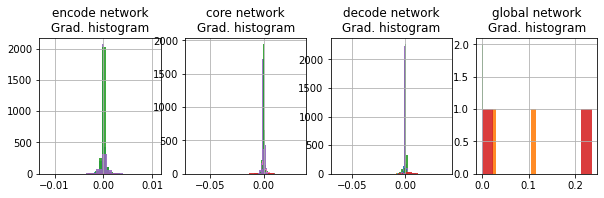

In [37]:
import matplotlib.pyplot as plt

sc = 0.5
plt.figure(figsize = (20*sc,5*sc))

plt.subplot(1,4,1)
for k,name in enumerate(['encode','core','decode','global']):
    plt.subplot(1,4,1+k)
    # Encode network:
    start_idx, end_idx = cumsum_nweights_per_block[k:k+2]
    for g_ in grads[start_idx:end_idx]:
        plt.hist(g_.numpy().flatten(), alpha = 0.9)

    plt.grid()
    plt.title("%s network\nGrad. histogram"%name)

#TODO: 
Implement and test `tf.function` examples.